In [1]:
# pipenv install pandas scipy tensorboard plotly scikit-learn catboost shap ipykernel ipywidgets nbformat

In [2]:
import pandas as pd 
import numpy as np 
from scipy.stats import chi2_contingency, f_oneway, ttest_ind
from colorama import Fore, Back, Style

pd.set_option('display.float_format', lambda x: '%.3f' % x)
np.set_printoptions(suppress=True, precision=3)

import plotly.express as px
import matplotlib.pyplot as plt 
from sklearn.tree import plot_tree

from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, log_loss, roc_curve, roc_auc_score

import shap

### Carregar Dados

In [3]:
df_empresas = pd.read_csv(r'.\datasets\empresas.csv')

In [4]:
df_empresas.head(10)

,ID,Nome_Empresa,Receita_Anual,Margem_Liquida,Endividamento,Setor,Regiao,Tempo_Operacao,Auditoria_Externa,Rating_Credito,...,Estrategia_Expansao,Gestao_Risco,Cobertura_Seguros,Maturidade_Digital,Governanca_Corporativa,Cultura_Inovacao,Relacao_Comunidade,Risco_Credito,Risco_Compliance,Risco_Mercado
0,1,Hahn Group,6523388,0.483,1.033,Manufatura,Europa,26,0,0.939,...,Parcerias,Centralizada,Básica,Avançada,Fraca,Neutra,Regular,0,0,0
1,2,Lopez Group,6650634,0.121,0.493,Tecnologia,Europa,20,1,0.492,...,Orgânica,Centralizada,Básica,Inicial,Média,Neutra,Ruim,0,0,0
2,3,Sparks and Sons,4404572,0.190,0.757,Manufatura,América Latina,6,0,0.701,...,Orgânica,Decentralizada,Básica,Inicial,Alta,Neutra,Boa,0,0,0
3,4,"Fields, Ramirez and Craig",2334489,0.402,2.328,Manufatura,Europa,6,1,0.856,...,Parcerias,Centralizada,Nenhuma,Intermediária,Média,Inovadora,Excelente,1,0,0
4,5,"Campbell, Hernandez and Lyons",9624682,0.175,1.722,Saúde,América do Norte,18,1,0.418,...,Aquisições,Decentralizada,Nenhuma,Avançada,Fraca,Neutra,Regular,0,0,0
5,6,Robinson Ltd,7304212,-0.071,1.291,Saúde,América do Norte,4,1,0.309,...,Orgânica,Centralizada,Ampla,Avançada,Alta,Neutra,Ruim,1,0,1
6,7,Bennett LLC,9728519,0.010,0.131,Tecnologia,Ásia,17,0,0.937,...,Parcerias,Decentralizada,Básica,Avançada,Média,Neutra,Regular,0,1,0
7,8,"Rios, Stevens and Johnson",4572471,0.017,2.482,Saúde,Europa,14,1,0.516,...,Parcerias,Centralizada,Nenhuma,Intermediária,Alta,Neutra,Regular,1,0,0
8,9,"Murphy, Walters and Cruz",4623669,0.078,1.711,Tecnologia,América Latina,14,0,0.497,...,Aquisições,Decentralizada,Básica,Avançada,Média,Neutra,Ruim,0,1,0
9,10,Larson Ltd,7504852,0.099,0.861,Financeiro,América Latina,13,0,0.178,...,Aquisições,Centralizada,Básica,Intermediária,Média,Conservadora,Boa,1,1,0


In [5]:
df_empresas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ID                         1000 non-null   int64  
 1   Nome_Empresa               1000 non-null   object 
 2   Receita_Anual              1000 non-null   int64  
 3   Margem_Liquida             1000 non-null   float64
 4   Endividamento              1000 non-null   float64
 5   Setor                      1000 non-null   object 
 6   Regiao                     1000 non-null   object 
 7   Tempo_Operacao             1000 non-null   int64  
 8   Auditoria_Externa          1000 non-null   int64  
 9   Rating_Credito             1000 non-null   float64
 10  Tipo_Empresa               1000 non-null   object 
 11  Politica_Sustentabilidade  1000 non-null   object 
 12  Estrategia_Expansao        1000 non-null   object 
 13  Gestao_Risco               1000 non-null   object

In [6]:
# Valores possiveis para variaveis categoricas

for col in df_empresas.drop(columns=['Nome_Empresa'], axis=1).select_dtypes(include=['object']).columns:
    print(f'Coluna: {col}\nValores Possíveis: {df_empresas[col].unique()}\n')

Coluna: Setor
Valores Possíveis: ['Manufatura' 'Tecnologia' 'Saúde' 'Financeiro']

Coluna: Regiao
Valores Possíveis: ['Europa' 'América Latina' 'América do Norte' 'Ásia']

Coluna: Tipo_Empresa
Valores Possíveis: ['MEI' 'S.A.' 'Limitada' 'Multinacional']

Coluna: Politica_Sustentabilidade
Valores Possíveis: ['Baixa' 'Alta' 'Média']

Coluna: Estrategia_Expansao
Valores Possíveis: ['Parcerias' 'Orgânica' 'Aquisições']

Coluna: Gestao_Risco
Valores Possíveis: ['Centralizada' 'Decentralizada']

Coluna: Cobertura_Seguros
Valores Possíveis: ['Básica' 'Nenhuma' 'Ampla']

Coluna: Maturidade_Digital
Valores Possíveis: ['Avançada' 'Inicial' 'Intermediária']

Coluna: Governanca_Corporativa
Valores Possíveis: ['Fraca' 'Média' 'Alta']

Coluna: Cultura_Inovacao
Valores Possíveis: ['Neutra' 'Inovadora' 'Conservadora']

Coluna: Relacao_Comunidade
Valores Possíveis: ['Regular' 'Ruim' 'Boa' 'Excelente']



In [7]:
# Estatistica das variaveis numericas
df_empresas.describe()

,ID,Receita_Anual,Margem_Liquida,Endividamento,Tempo_Operacao,Auditoria_Externa,Rating_Credito,Risco_Credito,Risco_Compliance,Risco_Mercado
count,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000
mean,500.500,4992927.505,0.152,1.318,25.367,0.496,0.487,0.595,0.206,0.110
std,288.819,2804931.116,0.200,0.701,14.104,0.500,0.293,0.491,0.405,0.313
min,1.000,139353.000,-0.200,0.100,1.000,0.000,0.001,0.000,0.000,0.000
25%,250.750,2646177.750,-0.021,0.692,13.000,0.000,0.232,0.000,0.000,0.000
50%,500.500,5032603.000,0.160,1.364,25.000,0.000,0.476,1.000,0.000,0.000
75%,750.250,7270657.750,0.324,1.920,38.000,1.000,0.742,1.000,0.000,0.000
max,1000.000,9989550.000,0.500,2.499,49.000,1.000,0.999,1.000,1.000,1.000


### EDA

In [8]:
numeric_features = df_empresas.drop(columns=['ID', 'Risco_Credito', 'Risco_Compliance', 'Risco_Mercado']).select_dtypes(include=['number']).columns

In [9]:
numeric_features

Index(['Receita_Anual', 'Margem_Liquida', 'Endividamento', 'Tempo_Operacao',
       'Auditoria_Externa', 'Rating_Credito'],
      dtype='object')

In [10]:
for col in numeric_features:
    fig = px.histogram(df_empresas, x=col, nbins=20, title=f"Distribuição de {col}")
    fig.show()

In [11]:
categorical_features =  df_empresas.drop(columns=['Nome_Empresa'], axis=1).select_dtypes(include=['object']).columns

In [12]:
categorical_features

Index(['Setor', 'Regiao', 'Tipo_Empresa', 'Politica_Sustentabilidade',
       'Estrategia_Expansao', 'Gestao_Risco', 'Cobertura_Seguros',
       'Maturidade_Digital', 'Governanca_Corporativa', 'Cultura_Inovacao',
       'Relacao_Comunidade'],
      dtype='object')

In [13]:
for col in categorical_features:
    df_count = df_empresas[col].value_counts().reset_index() 
    df_count.columns = ['categoria', 'contagem']
    fig = px.bar(df_count,
                 x='categoria',
                 y='contagem',
                 title=f'Contagem por categoria de {col}',
                 )
    fig.show()

In [14]:
# Lista de target
targets = ['Risco_Credito', 'Risco_Compliance', 'Risco_Mercado']

In [15]:
for col in targets:
    df_count = df_empresas[col].value_counts().reset_index() / len(df_empresas) * 100
    df_count.columns = ['categoria', 'contagem']
    fig = px.bar(df_count,
                 x='categoria',
                 y='contagem',
                 title=f'Contagem por {col}',
                 )
    fig.show()

In [16]:
# Analisar relacao entre feature numericas e categoricas e targets
for target in targets:
    for col in numeric_features:
        fig = px.box(df_empresas, x=target, y=col, title=f'{col} por {target}')
        fig.show()
    
    for col in categorical_features:
        fig = px.histogram(df_empresas, x=col,color=target, barmode='group', title=f'{col} por {target}')
        fig.show()

In [17]:
correlation_matrix = df_empresas[numeric_features.tolist() + targets].corr()

fig = px.imshow(correlation_matrix, 
                color_continuous_scale='Viridis',
                title='Matriz de Correlação',
                zmin=-1,
                zmax=1)

fig.update_traces(text=correlation_matrix,
                  texttemplate='%{text:.1%}',
                  textfont=dict(size=9))

fig.update_layout(width=1000,
                  height= 600,
                  title_font=dict(size=14),
                  font=dict(size=10)
                  )

fig.show()

In [18]:
# ANOVA - Análise de Variância (diferença significativa média entre 3 ou mais grupos)
# T-Student - (diferença significativa média entre 2 grupos)

for col in numeric_features:
    for target in targets:
        groups = [df_empresas[df_empresas[target] == val][col] for val in df_empresas[target].unique()]
        if df_empresas[target].nunique() <=2:
            stat, pvalue = ttest_ind(*groups)
            teste = 'T-Test'
        elif df_empresas[target].nunique() >2:
            stat, pvalue = f_oneway(*groups)
            teste = 'ANOVA'
        print(f'{Fore.RED if pvalue < 0.05 else Fore.WHITE}'
                f'{teste} entre {col} e {target}: p-valor = {pvalue}')

T-Test entre Receita_Anual e Risco_Credito: p-valor = 0.9148230907469925
T-Test entre Receita_Anual e Risco_Compliance: p-valor = 0.37245390731630845
T-Test entre Receita_Anual e Risco_Mercado: p-valor = 1.4322662899167404e-06
T-Test entre Margem_Liquida e Risco_Credito: p-valor = 0.714839504289611
T-Test entre Margem_Liquida e Risco_Compliance: p-valor = 7.293209908090928e-67
T-Test entre Margem_Liquida e Risco_Mercado: p-valor = 0.4678700538767202
T-Test entre Endividamento e Risco_Credito: p-valor = 2.0286202656673824e-48
T-Test entre Endividamento e Risco_Compliance: p-valor = 0.02873944772709317
T-Test entre Endividamento e Risco_Mercado: p-valor = 0.6427051699118199
T-Test entre Tempo_Operacao e Risco_Credito: p-valor = 0.7368086294717284
T-Test entre Tempo_Operacao e Risco_Compliance: p-valor = 0.687526198825497
T-Test entre Tempo_Operacao e Risco_Mercado: p-valor = 9.253489005940335e-41
T-Test entre Auditoria_Externa e Risco_Credito: p-valor = 0.12610915002115405
T-Test entre A

### Preparação dos Dados

In [19]:
# Separar X e y
lista_colunas_indice = ['ID', 'Nome_Empresa']
X = df_empresas.drop(columns=lista_colunas_indice + targets, axis=1)
y = df_empresas[targets]

In [20]:
# Separar treino e teste
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.5, shuffle=True, random_state=51)


### Treinamento do Modelo CatBoost OnevsRest

In [21]:
catboost_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    l2_leaf_reg=3,
    cat_features=df_empresas.drop(columns=['Nome_Empresa']).select_dtypes(include=['object']).columns.tolist(),
    random_strength=2,
    loss_function='Logloss'
)


In [22]:
# Colocar o modelo na abordagem OnevsTest

ovr_model = OneVsRestClassifier(catboost_model)


In [23]:
ovr_model.fit(X_train, y_train)


0:	learn: 0.6294599	total: 197ms	remaining: 3m 16s
1:	learn: 0.5371508	total: 247ms	remaining: 2m 3s
2:	learn: 0.4570634	total: 288ms	remaining: 1m 35s
3:	learn: 0.3992278	total: 324ms	remaining: 1m 20s
4:	learn: 0.3453984	total: 361ms	remaining: 1m 11s
5:	learn: 0.2879831	total: 382ms	remaining: 1m 3s
6:	learn: 0.2466229	total: 425ms	remaining: 1m
7:	learn: 0.2199186	total: 447ms	remaining: 55.4s
8:	learn: 0.1955501	total: 490ms	remaining: 53.9s
9:	learn: 0.1666704	total: 526ms	remaining: 52.1s
10:	learn: 0.1487477	total: 555ms	remaining: 49.9s
11:	learn: 0.1338095	total: 588ms	remaining: 48.4s
12:	learn: 0.1238168	total: 632ms	remaining: 48s
13:	learn: 0.1154578	total: 655ms	remaining: 46.1s
14:	learn: 0.1006511	total: 685ms	remaining: 45s
15:	learn: 0.0906420	total: 720ms	remaining: 44.3s
16:	learn: 0.0819758	total: 758ms	remaining: 43.8s
17:	learn: 0.0743135	total: 786ms	remaining: 42.9s
18:	learn: 0.0669086	total: 814ms	remaining: 42s
19:	learn: 0.0614129	total: 835ms	remaining: 4

,estimator,<catboost.cor...0027F462E8C10>
,n_jobs,None
,verbose,0


### Análise dos Resultados e metricas

In [24]:
y_pred = ovr_model.predict(X_test)
y_pred

array([[1, 0, 0],
       [0, 0, 0],
       [1, 0, 0],
       ...,
       [0, 0, 0],
       [1, 0, 1],
       [0, 0, 0]], shape=(500, 3))

In [25]:
y_pred_proba = ovr_model.predict_proba(X_test)
y_pred_proba

array([[1.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   ],
       [0.999, 0.   , 0.   ],
       ...,
       [0.   , 0.   , 0.   ],
       [0.999, 0.   , 1.   ],
       [0.   , 0.   , 0.   ]], shape=(500, 3))

In [26]:
# Relatorio de classificacao

print('Relatorio de Classificação')
print(classification_report(y_test, y_pred))

Relatorio de Classificação
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       293
           1       0.98      1.00      0.99       105
           2       1.00      1.00      1.00        55

   micro avg       0.99      1.00      1.00       453
   macro avg       0.99      1.00      1.00       453
weighted avg       0.99      1.00      1.00       453
 samples avg       0.71      0.72      0.71       453



c:\Users\PC\.virtualenvs\ensemble_catboost-0jNP-qIe\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.

c:\Users\PC\.virtualenvs\ensemble_catboost-0jNP-qIe\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.

c:\Users\PC\.virtualenvs\ensemble_catboost-0jNP-qIe\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.




Matriz de Confusão para Risco_Credito

Matriz de Confusão para Risco_Compliance

Matriz de Confusão para Risco_Mercado


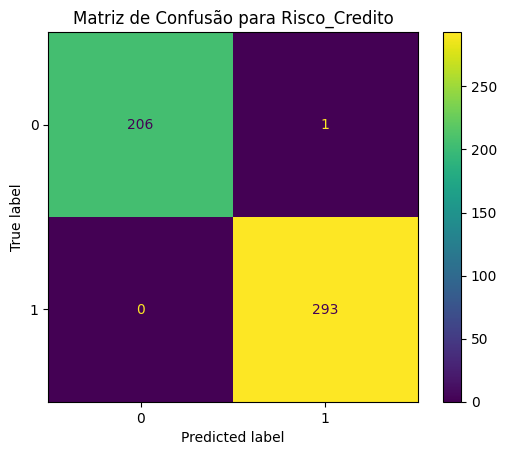

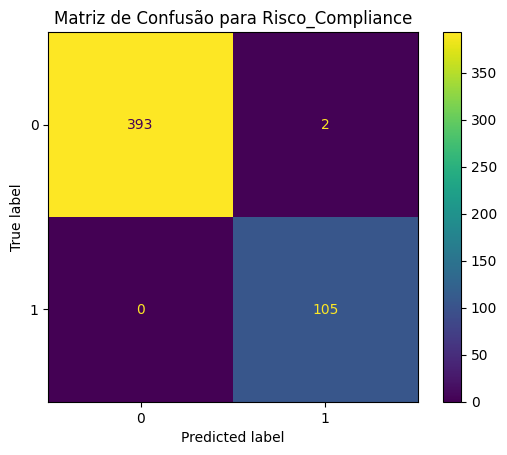

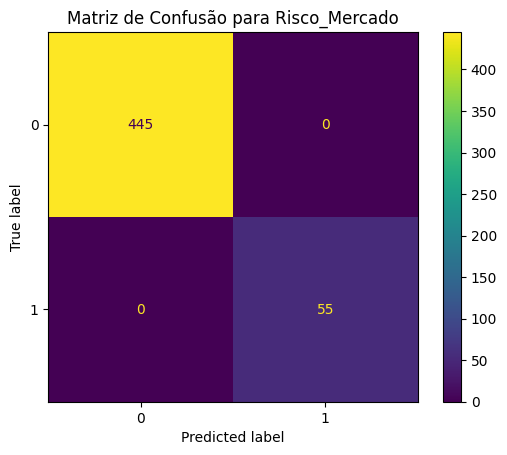

In [27]:
for i, target in enumerate(targets):
    print(f'\nMatriz de Confusão para {target}')
    conf_matrix = confusion_matrix(y_test.iloc[:,i], y_pred[:,i])
    fig = ConfusionMatrixDisplay(conf_matrix,
                                 display_labels=[0,1],
                                 )
    fig.plot()
    plt.title(f'Matriz de Confusão para {target}')
    

In [28]:
# Logloss
print(f'Logloss por target')
for i, target in enumerate(targets):
    log_loss_score = log_loss(y_test.iloc[:,i], y_pred[:,i])
    print(f'{target}: {log_loss_score:.4f}')

Logloss por target
Risco_Credito: 0.0721
Risco_Compliance: 0.1442
Risco_Mercado: 0.0000


### Interpretabilidade

In [29]:
# importancia das features para cada target

for i, target in enumerate(targets):
    #Obter importancia
    importance_feature = ovr_model.estimators_[i].feature_importances_
    nomes_features = X.columns.tolist()
    
    # Criar df
    df_importances = pd.DataFrame({'Feature': nomes_features, 'Importancia': importance_feature})
    df_importances = df_importances.sort_values(by='Importancia', ascending=False).reset_index(drop=True)
    
    fig = px.bar(
        df_importances.head(10),
        x='Importancia',
        y='Feature',
        orientation='h',
        title=f"Importancia das Features - {target}",
        color='Importancia',
        color_continuous_scale='ArmyRose'
    )
    
    fig.update_layout(
        height= 600,
        yaxis={'categoryorder': 'total ascending'}
    )
    
    fig.show()

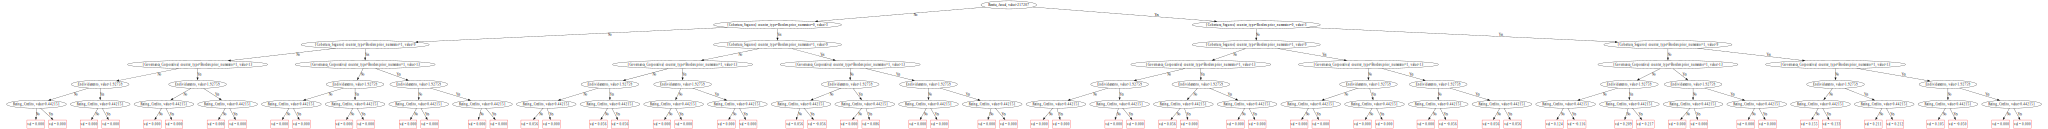

In [30]:
# visualizar modelo de arvore

modelo_catboost = ovr_model.estimators_[0]

# Criar o Pool com os dados do treinamento


pool = Pool (
    data=X_train,
    label = y_train.iloc[:,0],
    cat_features = categorical_features.tolist(),
    feature_names = list(X_train.columns)
)

modelo_catboost.plot_tree(tree_idx=0, pool = pool)

In [31]:
# Shap Values 

# Criar e rodar os explainers para cada target

explainers = []
shap_values = []

for i, target in enumerate(targets):
    print(f"Calculando SHAP values para {target}...")
    
    # Usar TreeExplainer especifico para CatBoost
    explainer = shap.TreeExplainer(ovr_model.estimators_[i])
    
    # Calcular valores SHAP
    shap_values_target = explainer.shap_values(X_test)
    
    # Atualizo as listas
    explainers.append(explainer)
    shap_values.append(shap_values_target)

Calculando SHAP values para Risco_Credito...
Calculando SHAP values para Risco_Compliance...
Calculando SHAP values para Risco_Mercado...


Gráfico SHAP para Risco_Credito:


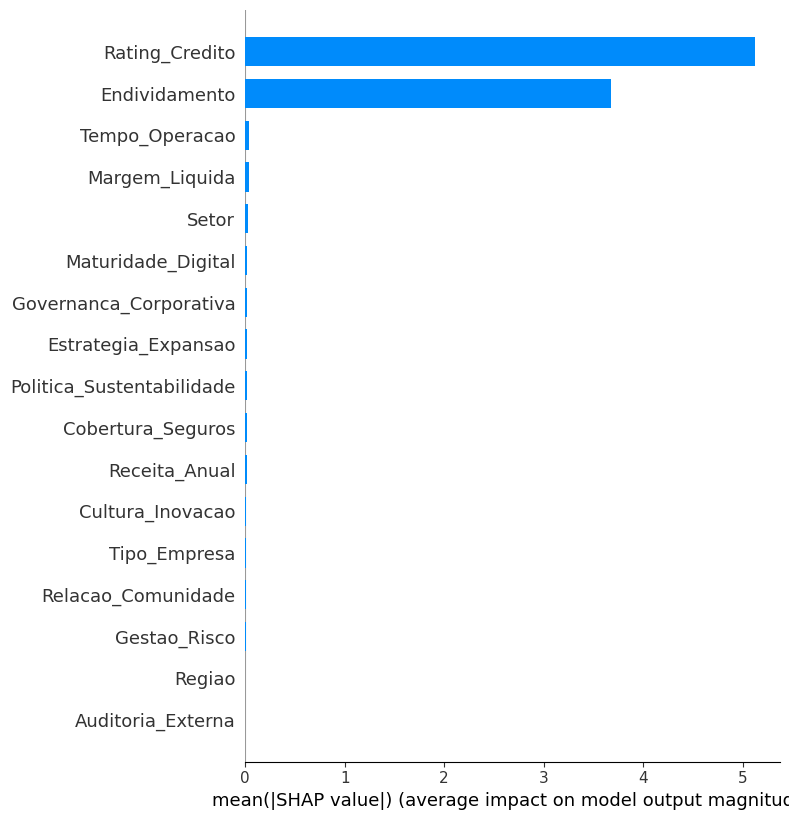

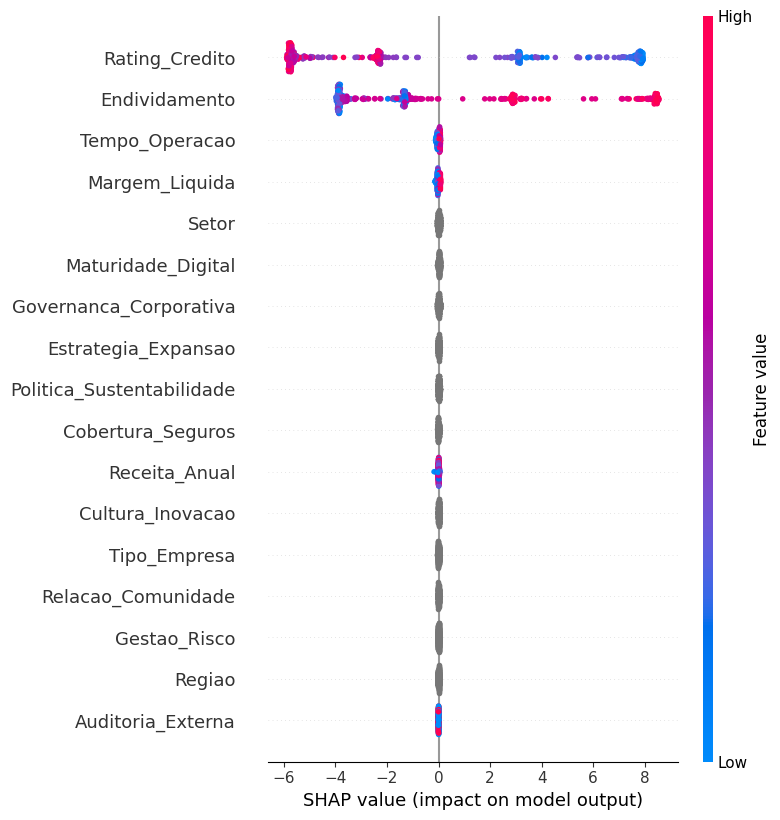

Gráfico SHAP para Risco_Compliance:


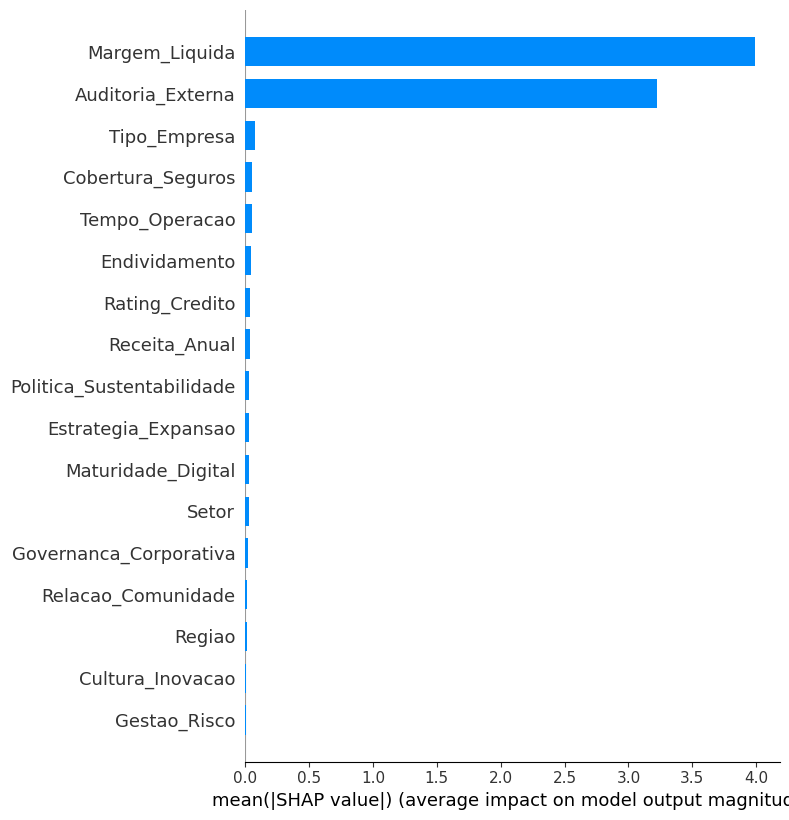

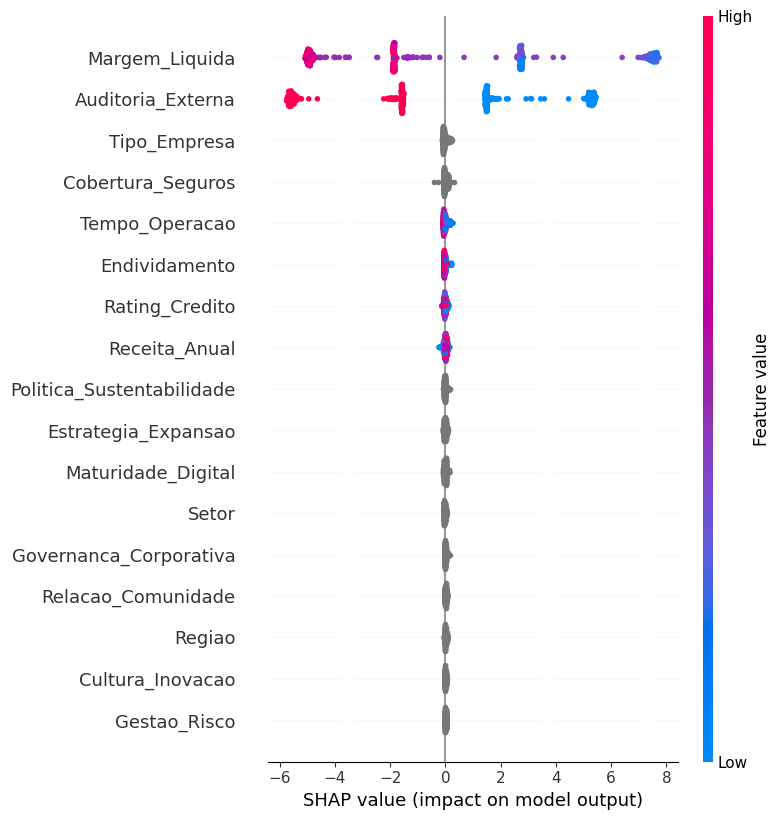

Gráfico SHAP para Risco_Mercado:


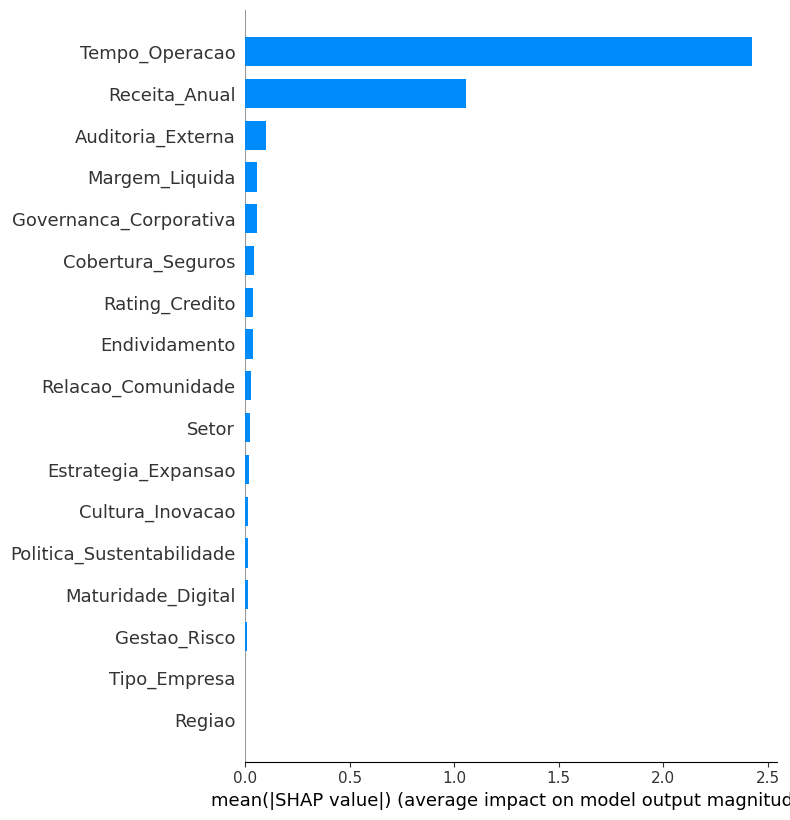

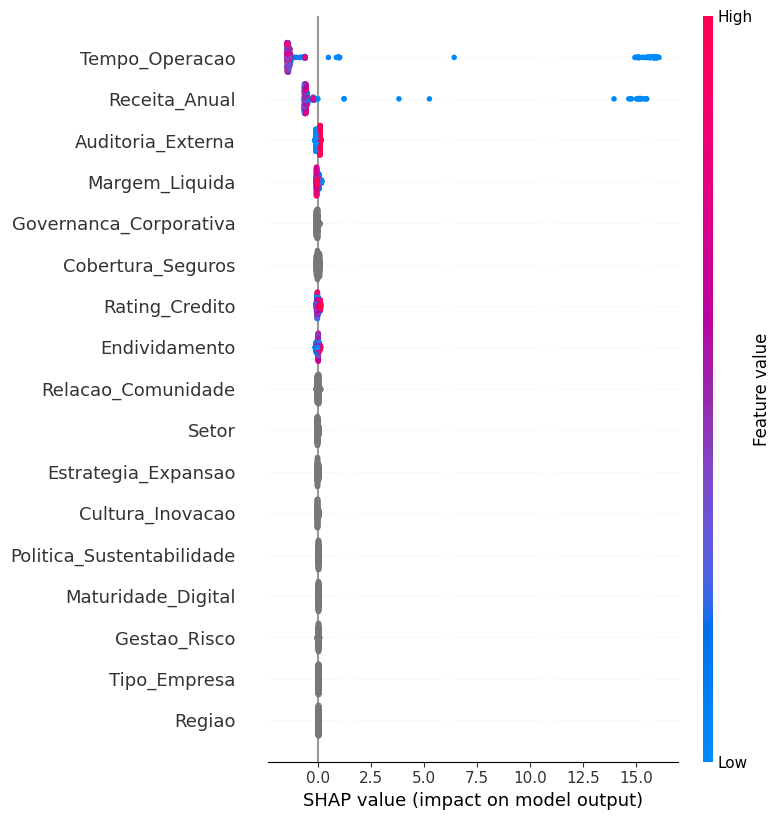

In [34]:
for i, target in enumerate(targets):
    print(f"Gráfico SHAP para {target}:")
    
    shap.summary_plot(
        shap_values[i],
        X_test,
        plot_type='bar',
        title=f'Contribuição Global das variáveis para {target}',
        show=False
    )
    
    plt.tight_layout()
    plt.show()
    
    shap.summary_plot(
        shap_values[i],
        X_test,
        title=f'Distribuição dos valores SHAP {target}',
        show=False
    )
    
    plt.tight_layout()
    plt.show()
    
    